In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce
from scipy.stats import ttest_1samp

# Results preparation

In [2]:
datasets = ["dna", "./english", "./mono", "./random"]
nameDatasets = ["dna", "english", "mono", "random"]
prefix = "datasets/"
suffix_SAM = "SAM_results.csv"
suffix_naive = "naive.csv"


In [3]:
collected_naive_results = []
collected_SAM_results = []
for dataset in datasets:
    collected_naive_results.append(pd.read_csv(prefix + dataset + "/" + suffix_naive))
    collected_SAM_results.append(pd.read_csv(prefix + dataset + "/" + dataset + suffix_SAM))

# Dataset view

A verification step to ensure the result sets for comparison are of equal size


In [4]:
len(collected_SAM_results), len(collected_naive_results)

(4, 4)

Assume we have input text $T$, where we want to search some pattern $P_i$. Each row with index $i$ corresponds to some pattern $P_i$. Let's describe each column.
* Column **length** represents the length of pattern $P_i$ stored in each row.
* Column **occurrences** represents how many times pattern $P_i$ occurs in text $T$.
* Column **time[ns]** means how many nanoseconds it takes to find **all** occurrences of pattern $P_i$ in the text $T$. More exactly, we measure how many nanoseconds method method math_all(P) needs to process pattern P.
    - Because it is required to find all occurrences, it is a good practise to use normalization, where we want to know how much time we need per one occurrence of pattern $P_i$.
* Column **states** describes how many states SA needs to build upon text $T$. For each pattern $P_i$ SA has the same amount of states. Therefore it is sufficient to save it only once.
* Column **time_build** describes how many nanoseconds we need to build SA.


In following two cells we demonstrate only part of results for each approach (SA and naive algoritm).

In [5]:
collected_SAM_results[0][:5]

,length,occurrences,time[ns],states,transitions,time_build
0,5,1513,1832625,1739736,2641078,4077740834
1,5,1560,2007458,-,-,-
2,5,1448,1727083,-,-,-
3,5,1197,1430083,-,-,-
4,5,2813,3431125,-,-,-


In [6]:
collected_naive_results[0][:5]

,length,occurences,time[ns]
0,5,1513,2510147
1,5,1560,2549119
2,5,1448,2782953
3,5,1197,2562460
4,5,2813,2628880


Here we want to see how much time we pay for each occurrence of the pattern in the text: $\text{time\_per\_occurrence} = \frac{\text{time[ns]}}{\text{occurrences}}$.

In [7]:
normalized_SAM_time = [collected_SAM_results[i]["time[ns]"] / collected_SAM_results[i]["occurrences"] for i in range(len(collected_SAM_results))]


# Visualization


 We need to group strings according to their length. Boundaries represent where the group of a specific length starts and where it ends.

In [8]:
def calc_boundaries(dataset, collumn):
    lengths = dataset[collumn] 
    unique_lengths = lengths.unique()
    
    boundaries = []
    current_len = unique_lengths[0]

    for i, L in enumerate(lengths):
        if L != current_len:
            boundaries.append(i-1)
            current_len = L
    return boundaries        
calc_boundaries(collected_SAM_results[0], 'length') # test

[10, 21, 32, 43, 54]

For each dataset specified in the task, we calculate log-scaled time when it finds patterns in the text using the naive method and when we use suffix automaton (SA).

What is worth mentioning, we calculate only searching time for SA, we do not include the time needed to construct the automaton upon the input text. However, we include it in a further section, where we want to see how many pattern queries we need to make so that SA building time pays off.

On x-axis we have groups separated by vertical lines and made of strings with the same length. In the experiment we have groups of strings with length 10, 21, 32, 43, 54.

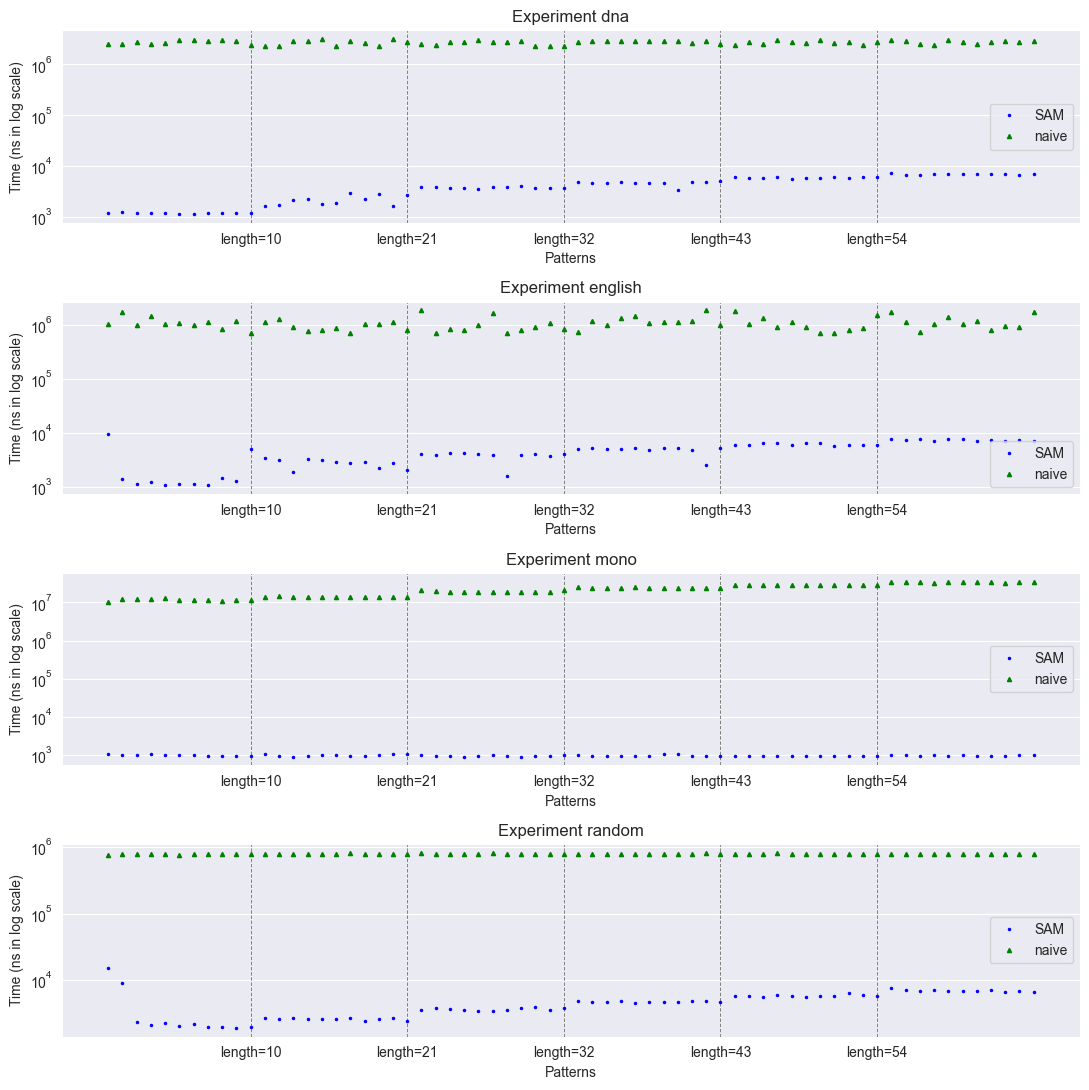

In [9]:
fix, axes = plt.subplots(len(collected_SAM_results),1,figsize=(11,11))
for i in range(len(collected_SAM_results)):
    length_boundaries = calc_boundaries(collected_naive_results[i], 'length')
    label_length_boundaries = []
    for b in length_boundaries:
        axes[i].axvline(b, color='gray', linestyle='--', linewidth=0.7)
        label_length_boundaries.append(f"length={b}")
    axes[i].set_xticks(length_boundaries)
    axes[i].set_xticklabels(label_length_boundaries) 
    axes[i].plot(normalized_SAM_time[i],  'b.', markersize=3, label='SAM')
    axes[i].plot(collected_naive_results[i]['time[ns]'],  'g^', markersize=3, label='naive')
    axes[i].set_ylabel("Time (ns in log scale)")
    axes[i].set_xlabel("Patterns")
    axes[i].set_title(f"Experiment {nameDatasets[i]}")
    axes[i].set_yscale("log")
    axes[i].legend()
plt.tight_layout()
plt.savefig("images/experiments.png")
plt.show()    

# Statistic test

In this section we want to see if SA outperforms the naive algorithm in pattern matching. We need to note again that we calculated only queries of patterns and did not include the building time of SA in this statistical test. For that purpose, we use a one-sample t-test where we study the expectation value.

At first we merge results from each dataset, and then for each pattern we see how well SA performs compared to the naive approach. More precisely, if the difference between two measured results equals 0, it means the two algorithms need the same amount of time to find the pattern in the text. If the difference is positive, it means that SA takes more time to find a pattern than the naive approach. Analogously, if the difference is negative, SA is faster.

Using these differences, we run a one-sample t-test on the mean. The null hypothesis is that the expectation value is zero, which means there is no difference in average time. The alternative hypothesis is that the expectation value is not equal to zero. We choose the significance level $\alpha = 0.01$.

In [10]:
merged_naive_results          = reduce( lambda x, y : pd.concat([x['time[ns]'].to_frame(), y['time[ns]'].to_frame()]), collected_naive_results)
merged_SAM_normalized_results = reduce( lambda x, y : pd.concat([x, y]), normalized_SAM_time)

In [11]:
diff = merged_SAM_normalized_results - merged_naive_results["time[ns]"]
t_stat, p_value = ttest_1samp(diff, popmean=0)

print("t-stat:", t_stat)
print("p-value:", p_value)

t-stat: -11.055138233153384
p-value: 1.3849374318042768e-23


According to the t-test, we see that we reject null hypothesis on significance level $\alpha=0.01$

# When does SA pay off compared to the naive approach?


In contrast to the other section, where we see that queries of SA are very cheap for each dataset, we now include the building time that SA requires for the input text. More precisely, we want to measure how many queries of each pattern we need to make so that SA pays off. The following section answers that question.


Let’s see how we will calculate what is worth. For SA we define the total time as the time it takes to build SA and then make $n$ queries for a pattern: $$T_{build} + n \cdot T_{SA}.$$ For the naive approach we only make $n$ queries, which in summary takes: $$n \cdot T_{naive}. $$ And we want to see when the following inequality holds: $$T_{build} + n \cdot T_{SA} < n \cdot T_{naive}.$$

Based on this, we define the border value $n_{border}$ as the point where the inequality
$T_{build} + n \cdot T_{SA} < n \cdot T_{naive}$ starts to hold. Equivalently, we can rewrite it as: $$ n_{border} = \frac{T_{build}}{T_{naive} - T_{SA}}.$$


In [12]:
T_build_datasets = []
n_border = []
for i in range(len(collected_SAM_results)):
    T_build_datasets.append(pd.to_numeric(collected_SAM_results[i]["time_build"][0]))
    diff = collected_naive_results[i]["time[ns]"] - normalized_SAM_time[i]
    diff = diff.replace(0, np.nan)
    n_border.append(T_build_datasets[i]/diff)

Here we show the distribution for each dataset, where we count how many queries we need to make for each pattern in the text.

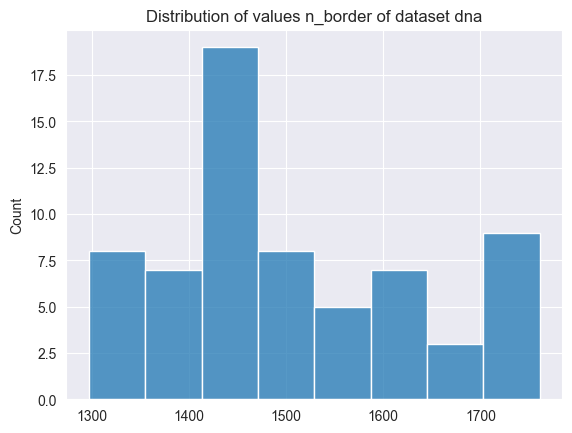

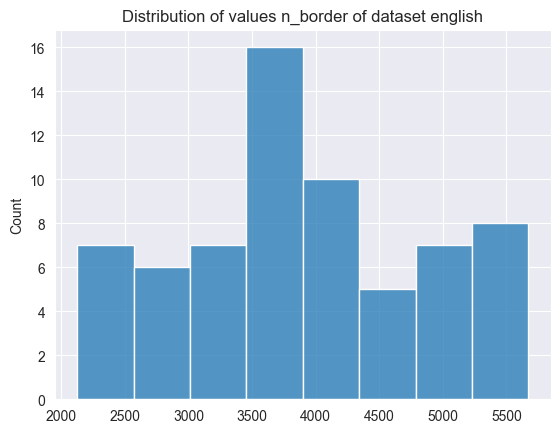

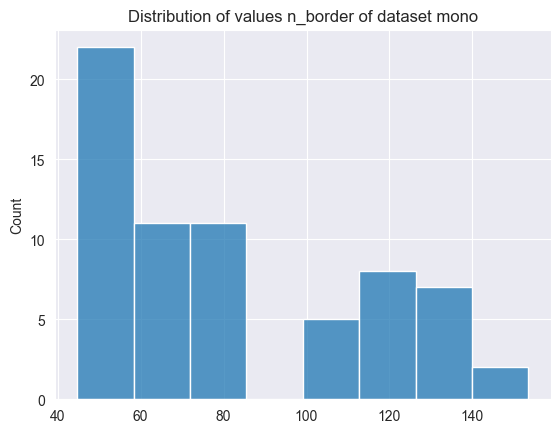

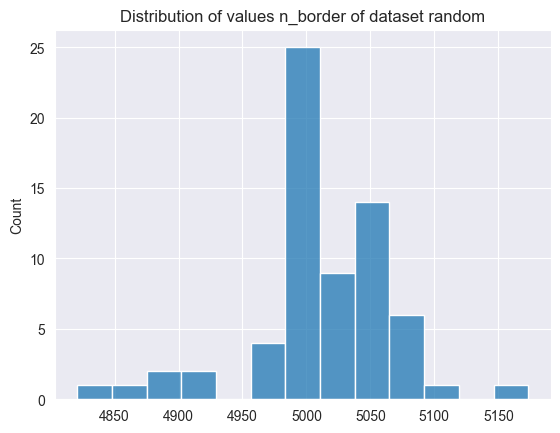

In [13]:
for idx, border in enumerate(n_border):
    sns.histplot(border)
    plt.title(f"Distribution of values n_border of dataset {nameDatasets[idx]}")
    plt.savefig(f"images/distribution_of_values_of_dataset_{nameDatasets[idx]}.png")
    plt.show()